# Compute Latency

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform latency analysis.

Similar to the _Collect Observations_ and _Compute Coverage_ examples, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width. Points are distributed over the globe with a 5000 km characteristic distance and observations are collected over a 30 day period starting on July 14, 2022 at noon UTC.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
    req_target_sunlit=True,
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

from tatc.generation import generate_cubed_sphere_points

points_df = generate_cubed_sphere_points(5000e3)

from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

from tatc.analysis import collect_observations
from joblib import Parallel, delayed
import pandas as pd

observations_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
observations = pd.concat(observations_list, ignore_index=True)
display(observations)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-26 23:05:45.077898+00:00,2022-07-26 23:08:44.767368+00:00,2022-07-26 23:07:14.922633+00:00,23.232253,96.383051
1,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-29 00:07:14.187520+00:00,2022-07-29 00:14:00.195900+00:00,2022-07-29 00:10:37.191710+00:00,44.280829,81.971247
2,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-29 23:48:34.454547+00:00,2022-07-29 23:54:41.391443+00:00,2022-07-29 23:51:37.922995+00:00,36.376684,86.224131
3,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-30 23:30:01.123712+00:00,2022-07-30 23:35:11.392518+00:00,2022-07-30 23:32:36.258115+00:00,29.980316,90.546787
4,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,2022-07-31 23:11:40.871422+00:00,2022-07-31 23:15:23.426119+00:00,2022-07-31 23:13:32.148770500+00:00,24.749626,94.926625
...,...,...,...,...,...,...,...,...,...
2327,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:34:03.183661+00:00,2022-08-12 18:31:26.254800+00:00,31.260813,324.671157
2328,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:48.545180+00:00,2022-08-12 21:49:15.681468+00:00,21.116289,13.096140
2329,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:31:03.448822+00:00,2022-08-12 23:28:19.433236+00:00,32.782441,37.026059
2330,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:11:46.499770+00:00,2022-08-13 01:08:03.229647+00:00,73.846580,59.292237


Latency analysis measures the interval between observations and downlink to the first ground station. The following specifies a ground station at Hoboken with a 10-degree minimum elevaiton angle for downlink.

In [2]:
from tatc.schemas import GroundStation

hoboken = GroundStation(
    name="Hoboken", latitude=40.74259, longitude=-74.02686, min_elevation_angle=10
)

from tatc.analysis import collect_downlinks

downlinks = collect_downlinks(hoboken, noaa20, start, end)
display(downlinks)

,station,geometry,satellite,start,end,epoch
0,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-14 17:12:43.783775+00:00,2022-07-14 17:22:57.443532+00:00,2022-07-14 17:17:50.613653500+00:00
1,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-14 18:54:04.803778+00:00,2022-07-14 19:02:24.959866+00:00,2022-07-14 18:58:14.881822+00:00
2,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 05:32:06.586963+00:00,2022-07-15 05:39:35.850388+00:00,2022-07-15 05:35:51.218675500+00:00
3,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 16:54:27.859081+00:00,2022-07-15 17:03:52.146143+00:00,2022-07-15 16:59:10.002612+00:00
4,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-07-15 18:34:28.301932+00:00,2022-07-15 18:44:07.965374+00:00,2022-07-15 18:39:18.133653+00:00
...,...,...,...,...,...,...
87,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-11 18:27:37.077327+00:00,2022-08-11 18:37:35.966333+00:00,2022-08-11 18:32:36.521830+00:00
88,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 05:09:06.247799+00:00,2022-08-12 05:11:04.388216+00:00,2022-08-12 05:10:05.318007500+00:00
89,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 08:28:06.674082+00:00,2022-08-12 08:32:42.220364+00:00,2022-08-12 08:30:24.447223+00:00
90,Hoboken,POINT Z (-74.02686 40.74259 0.00000),NOAA 20,2022-08-12 16:30:10.560649+00:00,2022-08-12 16:37:44.339077+00:00,2022-08-12 16:33:57.449863+00:00


Finally, latencies are computed by comparing the observations and downlink opportunities.

In [3]:
from tatc.analysis import compute_latencies

latencies = compute_latencies(observations, downlinks)
display(latencies)

,point_id,geometry,satellite,instrument,sat_alt,sat_az,station,downlinked,latency,observed
0,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,23.232253,96.383051,Hoboken,2022-07-27 05:10:20.152447500+00:00,0 days 06:03:05.229814500,2022-07-26 23:07:14.922633+00:00
1,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,44.280829,81.971247,Hoboken,2022-07-29 06:13:31.927716500+00:00,0 days 06:02:54.736006500,2022-07-29 00:10:37.191710+00:00
2,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,36.376684,86.224131,Hoboken,2022-07-30 05:54:36.620577+00:00,0 days 06:02:58.697582,2022-07-29 23:51:37.922995+00:00
3,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,29.980316,90.546787,Hoboken,2022-07-31 05:35:38.300419+00:00,0 days 06:03:02.042304,2022-07-30 23:32:36.258115+00:00
4,0,POINT Z (-157.51699 -67.51699 0.00000),NOAA 20,VIIRS,24.749626,94.926625,Hoboken,2022-08-01 05:16:36.756741500+00:00,0 days 06:03:04.607971,2022-07-31 23:13:32.148770500+00:00
...,...,...,...,...,...,...,...,...,...,...
2327,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,31.260813,324.671157,Hoboken,2022-08-13 08:11:51.974882500+00:00,0 days 13:40:25.720082500,2022-08-12 18:31:26.254800+00:00
2328,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,21.116289,13.096140,Hoboken,2022-08-13 08:11:51.974882500+00:00,0 days 10:22:36.293414500,2022-08-12 21:49:15.681468+00:00
2329,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,32.782441,37.026059,Hoboken,2022-08-13 08:11:51.974882500+00:00,0 days 08:43:32.541646500,2022-08-12 23:28:19.433236+00:00
2330,31,POINT Z (157.24514 67.38106 0.00000),NOAA 20,VIIRS,73.846580,59.292237,Hoboken,2022-08-13 08:11:51.974882500+00:00,0 days 07:03:48.745235500,2022-08-13 01:08:03.229647+00:00


Similar to _Coverage Analysis_, latency analysis can also be reduced to compute descriptive statistics for each observation point.

In [4]:
from tatc.analysis import reduce_latencies

reduced_results = reduce_latencies(latencies)
display(reduced_results)

,geometry,latency,samples
point_id,,,
0,POINT Z (-157.51699 -67.51699 0.00000),0 days 05:58:48.795874,26
1,POINT Z (-112.55097 -67.51699 0.00000),0 days 09:06:07.721909,26
2,POINT Z (-67.58495 -67.51699 0.00000),0 days 06:02:48.350006,24
3,POINT Z (-22.61894 -67.51699 0.00000),0 days 01:52:05.106818,24
4,POINT Z (22.34708 -67.51699 0.00000),0 days 05:03:36.986779,25
5,POINT Z (67.31310 -67.51699 0.00000),0 days 08:01:41.364035,25
6,POINT Z (112.27912 -67.51699 0.00000),0 days 02:54:09.325805,26
7,POINT Z (157.24514 -67.51699 0.00000),0 days 03:20:48.380798,27
8,POINT Z (-157.51699 -22.55097 0.00000),0 days 06:12:31.869875,36


Finally, GeoPlot can visualize the geospatial data.

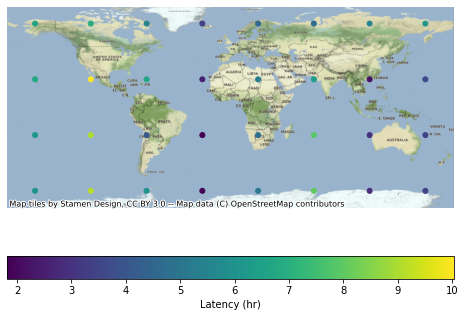

In [5]:
import geoplot as gplt
import contextily as ctx

reduced_results["latency_hr"] = reduced_results.latency / timedelta(hours=1)
ax = gplt.pointplot(
    reduced_results,
    hue="latency_hr",
    legend=True,
    legend_kwargs={"label": "Latency (hr)", "orientation": "horizontal"},
)
ctx.add_basemap(ax, crs=reduced_results.crs)

Similar to _Coverage Analysis_, cells can also be used to aggregate descriptive statistics.  Note that, when working on the reduced results, the revisit aggregation function must perform a weighted average based on the number of samples for each point.

In [6]:
from tatc.generation.cells import generate_cubed_sphere_cells

cells_df = generate_cubed_sphere_cells(5000e3)

import numpy as np

grid_results = (
    cells_df.sjoin(reduced_results, how="inner", predicate="contains")
    .dissolve(
        by="cell_id",
        aggfunc={
            "samples": "sum",
            "latency_hr": lambda r: np.average(
                r, weights=reduced_results.loc[r.index, "samples"]
            ),
        },
    )
    .reset_index()
)
display(grid_results)

,cell_id,geometry,samples,latency_hr
0,0,"POLYGON Z ((-135.03398 -90.00000 0.00000, -135...",26,5.980221
1,1,"POLYGON Z ((-90.06796 -90.00000 0.00000, -90.0...",26,9.102145
2,2,"POLYGON Z ((-45.10194 -90.00000 0.00000, -45.1...",24,6.046764
3,3,"POLYGON Z ((-0.13593 -90.00000 0.00000, -0.135...",24,1.868085
4,4,"POLYGON Z ((44.83009 -90.00000 0.00000, 44.830...",25,5.060274
5,5,"POLYGON Z ((89.79611 -90.00000 0.00000, 89.796...",25,8.028157
6,6,"POLYGON Z ((134.76213 -90.00000 0.00000, 134.7...",26,2.902591
7,7,"POLYGON Z ((179.72815 -90.00000 0.00000, 179.7...",27,3.346772
8,8,"POLYGON Z ((-135.03398 -45.03398 0.00000, -135...",36,6.208853
9,9,"POLYGON Z ((-90.06796 -45.03398 0.00000, -90.0...",36,9.031361


Finally, GeoPlot can illustrate the latency over global regions.

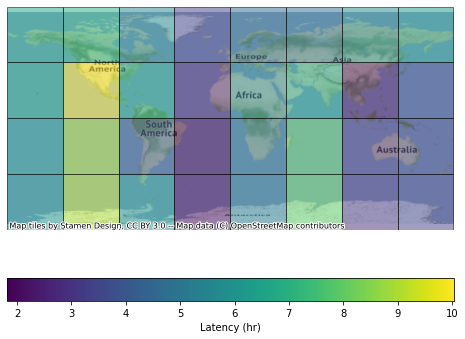

In [7]:
import geoplot as gplt
import contextily as ctx

ax = gplt.choropleth(
    grid_results,
    hue="latency_hr",
    alpha=0.5,
    legend=True,
    legend_kwargs={"label": "Latency (hr)", "orientation": "horizontal"},
)
ctx.add_basemap(
    ax,
    crs=reduced_results.crs,
)